# Event Study of IndianKanoon Rollout
Parse the text of judgements into a dataframe of relevant columns. Adjust the dataframe for the IK rollout by court. Compare the changes in various metrics pre and post IK rollout.  

In [3]:
import os 
import sys
import re
import time
import csv
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import ik_parsing as ik
import data_extraction as de
import helper_functions as hp
import defs
from datetime import datetime
from collections import defaultdict
import itertools
import zipfile
import gzip
import json
import concurrent.futures
from multiprocessing import Pool
import matplotlib.pyplot as plt
import math

head, tail = os.path.split(os.getcwd())

In [ ]:
import importlib
importlib.reload(ik)
importlib.reload(de)


if __name__ == '__main__':
    start = time.time()
    df = pd.DataFrame()
    courts = ['bombay', 'jharkhand', 'chattisgarh', 'jammu', 'andhra']
    dfs = []
                
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(de.extract_data, courts)

    for result in results:
        dfs.append(pd.DataFrame(result))

df = pd.concat(dfs)

print(f"--- {(time.time() - start)} seconds ---")  

print(df.shape)
df.head()

Takes ~1506 seconds with 500 limit break; took ~3 hours or so for all of MH, JH and CH courts. 
Usually 9-11 hours for all the data in 3 stages. Concat fails on all courts together hence the need for doing it in 3 broken down steps.

Adding more features based on existing columns.

In [48]:
df.reset_index(drop=True, inplace=True)
df['case_id'] = df['file'].apply(lambda x: x[x.rfind('/')+1:-4]) 

citation_counts = hp.citation_count_dict(df)

df['times_cited'] = df['case_id'].apply(lambda x: citation_counts.get(x, 0))

df['bench_size'] = df.loc[:,'judge'].dropna().apply(len)
        
df['num_citations'] = df.loc[:,'citations'].dropna().apply(len)

df['chief_justice'] = df.loc[:,'judge'].dropna().apply(lambda x: (any('chief' in item for item in x)))

keywords_state = ['state', 'government', 'commissioner', 'national', 'india', 'indian', 'public', 'magistrate',
                  'collector', 'department', 'district']
df['state'] = df.loc[:,'title'].dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_state)))

keywords_business = ['pvt', 'private', 'limited', 'ltd', 'company', 'co.', 'llp', 'llc']
df['business'] = (df.loc[:,'petitioner']+df.loc[:,'respondent']).dropna().apply(
    lambda x: (any(keyword in x.lower() for keyword in keywords_business)))

keywords_male = ['shri', 'mr.', 'master']
keywords_female = ['shrimati', 'mrs.', 'ms.', 'smt']

df.replace('\n', ' ', regex = True, inplace = True)
print(df.shape)
df.head()

The number of missing values. Try and get this to around 85-90% and above to proceed. Judges we are extracting at a reasonable accuracy. Next step is to optimize advocates but that is a lot more difficult. Will have to try NER or other approaches. 

In [14]:
df.isna().sum()

file                         0
cnr_num                1577932
title                        0
date                         0
court                        0
case_number            1408358
petitioner             1060541
respondent             1060541
petitioner_advocate    1550095
respondent_advocate    1576224
judge                    85665
banks                  1576195
citations               373272
bench_size               85665
num_citations           373272
chief_justice            85665
state                        0
business               1060541
case_id                      0
times_cited                  0
ik_rollout                   0
days_to_update               0
months_to_update             0
dtype: int64

In [ ]:
df.to_pickle('df_11courts.pkl')

## Start from Here
We have parsed all the basic case data into the dataframe. Pickle it so that you dont need to run above code every time you start this notebook. Instead you can start from below on. 

In [101]:
df = pd.read_pickle('df_allcourts.pkl')

# Gujarat dropped because the size of the dataframe is crashing the laptop
df = df[df.court!='Gujarat High Court'].reset_index(drop=True)
df = df[~df.court.isna()]

In [102]:
print(df.court.value_counts())

Madras High Court              470761
Jharkhand High Court           338969
Allahabad High Court           228124
Bombay High Court              221571
Himachal Pradesh High Court    131476
Bangalore District Court        67788
Gauhati High Court              64640
Chattisgarh High Court          59361
Jammu & Kashmir High Court      36713
Andhra High Court               14263
Name: court, dtype: int64


In [103]:
df.groupby(df.date.dt.strftime('%Y')).size()

date
2000      3955
2001      4849
2002      8769
2003      8852
2004      8834
2005      8709
2006     12366
2007     12582
2008      9966
2009     12191
2010     83620
2011     45764
2012     49289
2013     39700
2014     67325
2015    155688
2016    146459
2017    203641
2018    282016
2019    469091
dtype: int64

### Upload Dates
Based on Mr. Sinhas email detailing the rollout dates for each court, we creaste additional features to look at the case data and how far it was from the event - the rollout of IK. 

In [104]:
upload_dates = {'Gujarat High Court': datetime.strptime('2010-06-13', '%Y-%m-%d').date(),
                'Jharkhand High Court': datetime.strptime('2010-06-13', '%Y-%m-%d').date(),
                'Himachal Pradesh High Court': datetime.strptime('2017-04-15', '%Y-%m-%d').date(),
                'Allahabad High Court': datetime.strptime('2010-07-18', '%Y-%m-%d').date(),
                'Bangalore District Court': datetime.strptime('2017-02-01', '%Y-%m-%d').date(),
                'Madras High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Bombay High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Gauhati High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date() ,
                'Chattisgarh High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Jammu & Kashmir High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Andhra High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
               }

df['ik_rollout'] = df['court'].apply(lambda x: upload_dates.get(x, np.nan))
df.ik_rollout = pd.to_datetime(df.ik_rollout)
df.loc[:,'days_to_rollout'] = (df.loc[:, 'date'] - df.loc[:, 'ik_rollout'])
df.loc[:,'days_to_rollout'] = df.loc[:,'days_to_rollout'].astype('timedelta64[D]')
# df.loc[df.days_to_update>0,'days_to_update'] = 0
df.loc[:,'months_to_rollout'] = (df.loc[:,'days_to_rollout']/30).apply(math.floor)

In [106]:
df.head()

file cnr_num  \
0    chennai/2000/1001653.txt     NaN   
1    chennai/2000/1004399.txt     NaN   
2    chennai/2000/1004986.txt     NaN   
3  chennai/2000/100594719.txt     NaN   
4    chennai/2000/1006026.txt     NaN   

                                               title       date  \
0  Combined Engineering Industries ... vs Income ... 2000-11-06   
1        Arvind C' Bhagat vs Commissioner Of Customs 2000-06-29   
2  N. Palaniappan vs Government Of Tamil Nadu And... 2000-07-10   
3            C.Varghees Nadar (Died) vs V.Kamalakshi 2000-04-17   
4   Sounder Rajan vs Junior Engineer, Tamil Nadu ... 2000-03-01   

               court case_number petitioner respondent petitioner_advocate  \
0  Madras High Court         NaN        NaN        NaN                 NaN   
1  Madras High Court         NaN        NaN        NaN                 NaN   
2  Madras High Court         NaN        NaN        NaN                 NaN   
3  Madras High Court         NaN        NaN        NaN                 NaN   
4  Madras High Court         NaN        NaN        NaN                 NaN   

  respondent_advocate  ... bench_size num_cases_cited num_acts_cited  \
0                 NaN  ...        1.0               1              2   
1                 NaN  ...        1.0               0              2   
2                 NaN  ...        1.0               1              0   
3                 NaN  ...        1.0               2              5   
4                 NaN  ...        1.0               1              0   

  chief_justice  state  business  times_cited  ik_rollout days_to_rollout  \
0         False  False       NaN            0  2009-01-18         -2995.0   
1         False   True       NaN            0  2009-01-18         -3125.0   
2         False   True       NaN            0  2009-01-18         -3114.0   
3         False  False       NaN            0  2009-01-18         -3198.0   
4         False  False       NaN            0  2009-01-18         -3245.0   

  months_to_rollout  
0              -100  
1              -105  
2              -104  
3              -107  
4              -109  

[5 rows x 25 columns]

## Forward Citation
Forward citation is about looking at how the citations in the future of a case changes after the rollout of IK.

Create a dictionary where the key is a caseid that was uploaded on IK after its hearing date (not in realtime) and the value is the date it was uploaded

In [108]:
cases_prior = df.loc[df.months_to_rollout<0,['case_id','ik_rollout']].set_index('case_id').to_dict()['ik_rollout']

In [110]:
df.loc[df.months_to_rollout<0,'times_cited'].sum()

50382

In [111]:
df.loc[df.months_to_rollout<0,:].groupby('court').size()

court
Allahabad High Court           50149
Andhra High Court               9840
Bangalore District Court       44410
Bombay High Court              11547
Chattisgarh High Court          1090
Gauhati High Court              3322
Himachal Pradesh High Court     6860
Jammu & Kashmir High Court      1813
Jharkhand High Court           11151
Madras High Court              30884
dtype: int64

In [135]:
res_dict = defaultdict(int)

for row in df.itertuples():
    for citation in row.cases_cited:
        if citation in cases_prior:
            res_dict[round((row.date-cases_prior[citation]).days/30)] += 1

df_es = pd.DataFrame({'months_rollout':list(res_dict.keys()), 'num_citations':list(res_dict.values())})

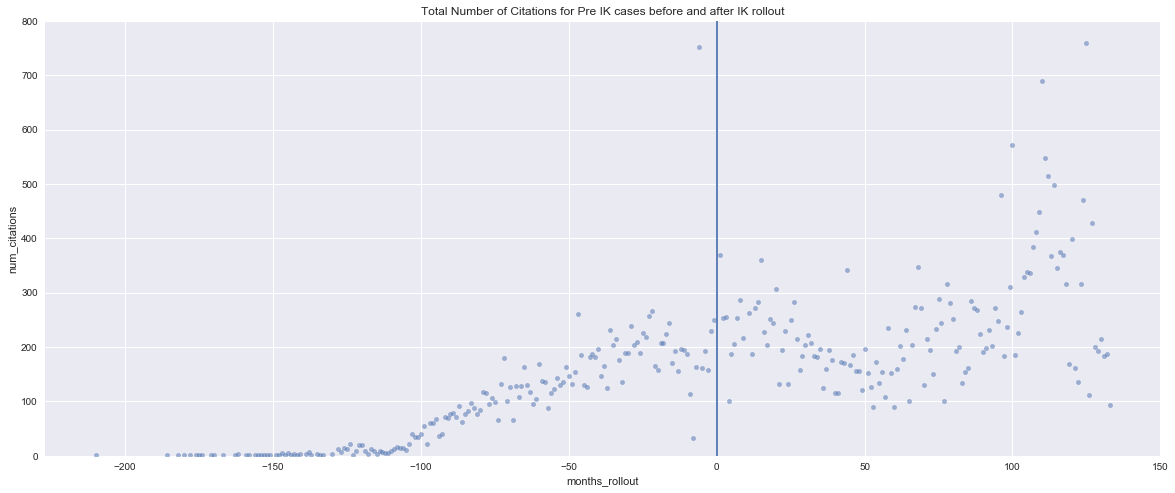

In [136]:
from numpy.polynomial import Polynomial
# df_es.set_index('index', inplace=True)
fig, ax = plt.subplots()
df_es.plot(x='months_rollout', y='num_citations', kind='scatter', ax = ax, figsize=(20,8), alpha=0.5, ylim=(0,800), title="Total Number of Citations for Pre IK rollout cases before and after IK rollout")
plt.axvline(0)
fig.savefig('plot2.png')
# p = Polynomial.fit(df_es.days, df_es.num_citations, 5)
# plt.plot(*p.linspace())

In [139]:
res_dict = defaultdict(int)

for row in df.itertuples():
    for citation in row.cases_cited:
        if citation in cases_prior:
            res_dict[round((row.date-cases_prior[citation]).days/30)] += 1

df_es = pd.DataFrame({'months':list(res_dict.keys()), 'num_citations':list(res_dict.values())})

In [140]:
cases_cited_monthly = df.groupby('months_to_rollout').count()['num_cases_cited'].to_dict()
for key, value in res_dict.items():
    res_dict[key] = res_dict[key]/cases_cited_monthly.get(key, 1)
df_es = pd.DataFrame({'months':list(res_dict.keys()), 'num_citations':list(res_dict.values())})

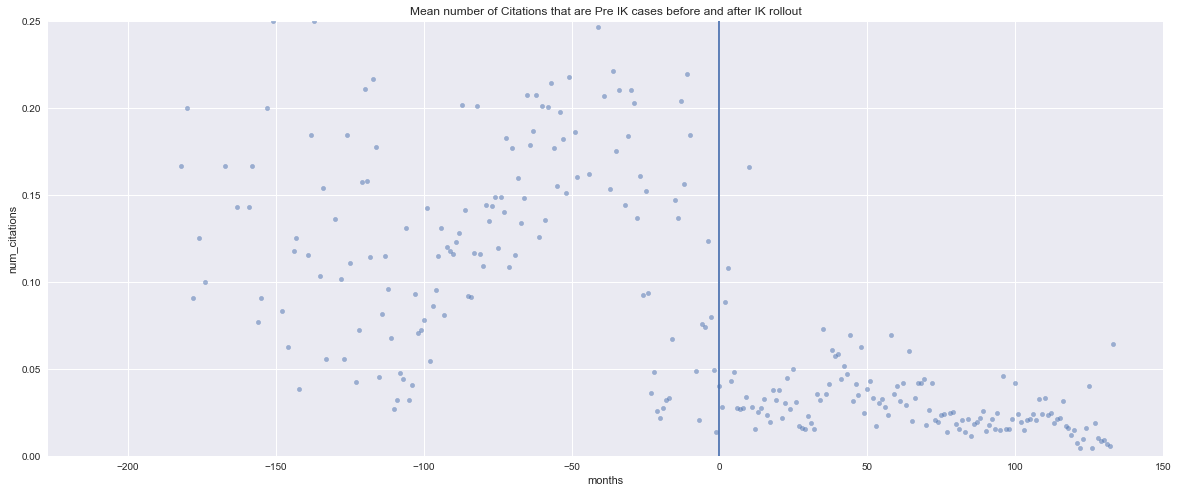

In [141]:
from numpy.polynomial import Polynomial
# df_es.set_index('index', inplace=True)
fig, ax = plt.subplots()
df_es.plot(x='months', y='num_citations', kind='scatter', ax = ax, figsize=(20,8), alpha=0.5,ylim=(0,0.25), title="Mean number of Citations that are Pre IK cases before and after IK rollout")
plt.axvline(0)
fig.savefig('plot3.png')

In [ ]:
res_dict = defaultdict(int)

for row in df.itertuples():
    for citation in row.cases_cited:
        if citation in cases_prior:
            res_dict[round((row.date-cases_prior[citation]).days/30)] += 1

df_es = pd.DataFrame({'months':list(res_dict.keys()), 'num_citations':list(res_dict.values())})

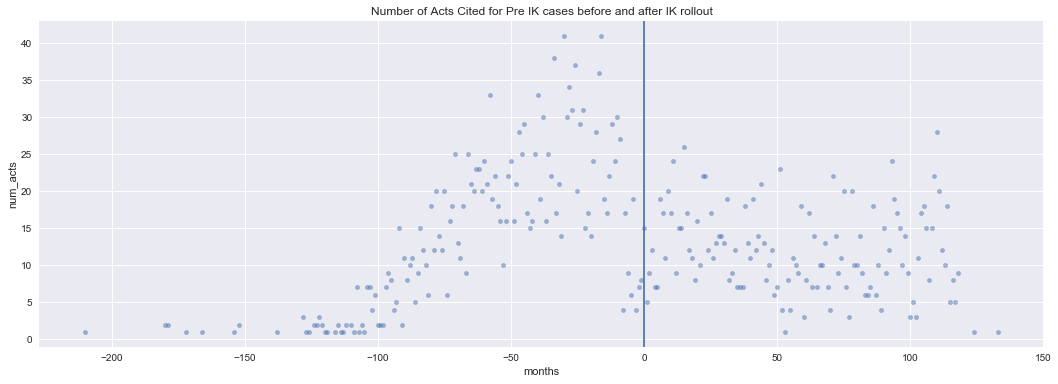

In [71]:
fig, ax = plt.subplots()
df_es_2 = pd.DataFrame({'months':list(res_dict.keys()), 'num_acts':list(res_dict.values())})
df_es_2.plot(x='months', y='num_acts', kind='scatter', ax=ax, figsize=(18,6), alpha=0.5, title="Number of Acts Cited for Pre IK cases before and after IK rollout")
# p = Polynomial.fit(df_es_2.days, df_es_2.num_acts, 2)
# plt.plot(*p.linspace())
plt.axvline(0)
# fig.savefig('plot3.png')

### Overview
Charting the number of cases and the mean number of citations by month across time based on event specification.

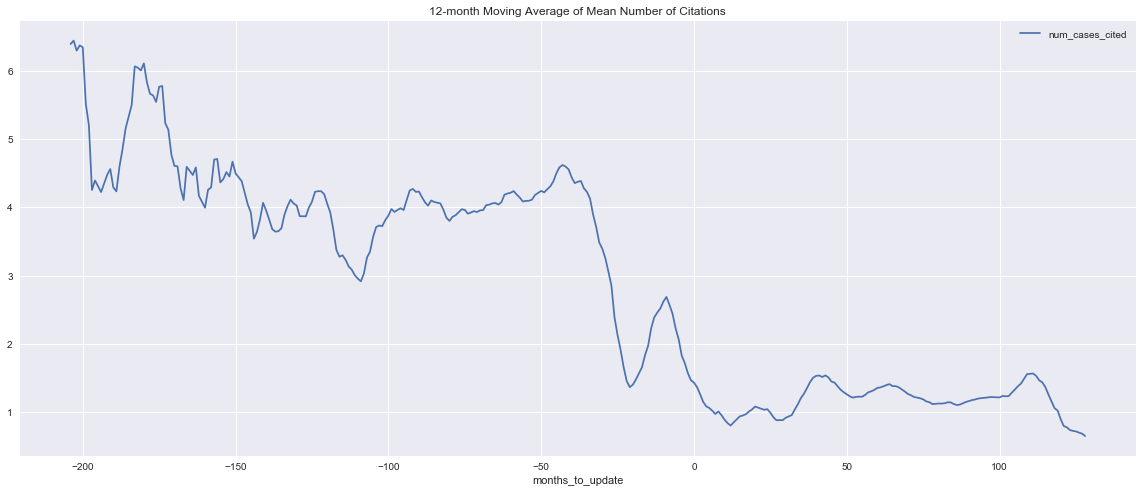

In [65]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
mean_citations_monthly = pd.DataFrame(df.groupby('months_to_update').mean()['num_cases_cited'])
mean_citations_monthly.rolling(12, center=True).mean().plot(figsize=(20,8), ax=ax, title='12-month Moving Average of Mean Number of Citations') #.plot(ax=ax, figsize=(18,6), alpha=0.5, title="Mean number of Citations by Month pre and post IK rollout")

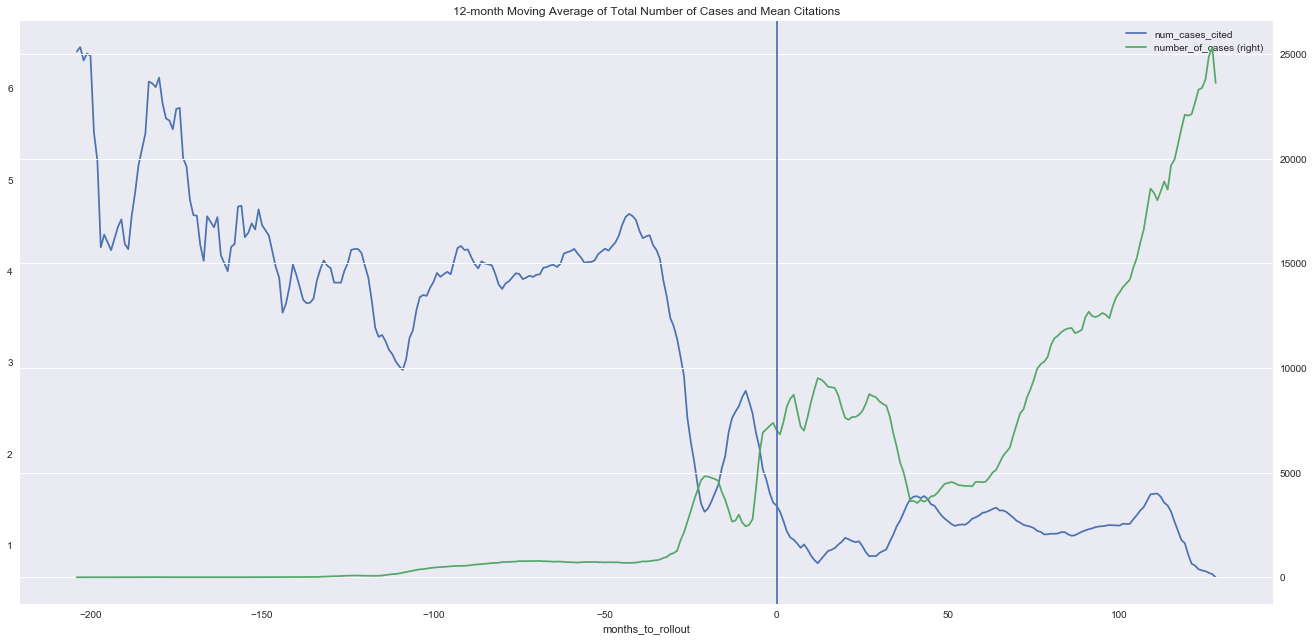

In [162]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
cases_by_time = pd.DataFrame(df.groupby('months_to_rollout').size())
mean_citations_monthly.rolling(12, center=True).mean().plot(figsize=(20,10), ax=ax) 
cases_by_time.columns = ['number_of_cases']
cases_by_time.rolling(12, center=True).mean().plot(ax=ax, secondary_y=True, title='12-month Moving Average of Total Number of Cases and Mean Citations')
plt.axvline(0)
fig.savefig('plot4.png')
# cases_by_time.plot(figsize=(20,8))

### Citation Diversity

In [142]:
def citation_diversity(df):
    hhi_indices = []
    for year in range(2000, 2020):
        for month in range(1,13):
            citation_counts_year = list(hp.citation_count_dict(df.loc[(df.date.dt.year==year)&(df.date.dt.month==month), :]).values())
            array_p_i = np.array(citation_counts_year)/sum(citation_counts_year)
            hhi = array_p_i * array_p_i * 10000
            hhi_indices.append(sum(hhi))
    return pd.DataFrame({'date': pd.date_range(start='2000/1/1', end='2019/12/1', freq='MS'), 'citation_diversity_index': hhi_indices})

citation_diversity_bombay = citation_diversity(df) 
citation_diversity_bombay.set_index('date', inplace=True)
citation_diversity_bombay = citation_diversity_bombay.rolling(12, center=True).mean()
citation_diversity_bombay

citation_diversity_index
date                                
2000-01-01                       NaN
2000-02-01                       NaN
2000-03-01                       NaN
2000-04-01                       NaN
2000-05-01                       NaN
...                              ...
2019-08-01                       NaN
2019-09-01                       NaN
2019-10-01                       NaN
2019-11-01                       NaN
2019-12-01                       NaN

[240 rows x 1 columns]

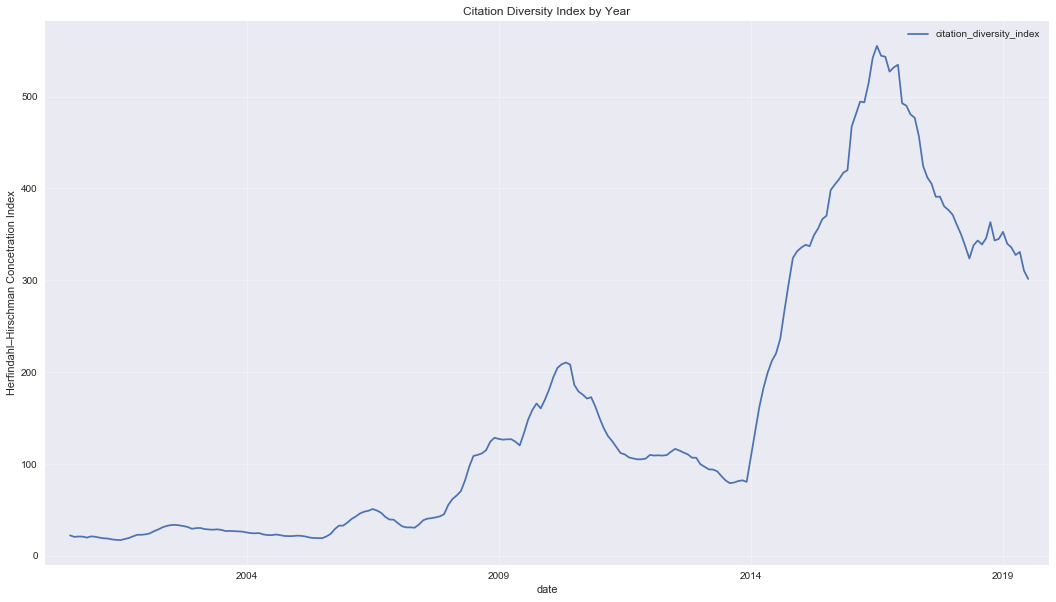

In [143]:
citation_diversity_bombay.index = pd.to_datetime(citation_diversity_bombay.index, format='%B-%Y')
fig, ax = plt.subplots()
plt.style.use('seaborn')
citation_diversity_bombay.plot(figsize=(18,10), ax=ax, title='Citation Diversity Index by Year')
ax.set_ylabel('Herfindahl–Hirschman Concetration Index')
plt.grid(alpha=0.3)
plt.axvline(0)
plt.savefig('plot5.png')

Citation Diveristy by event specification as opposed to by calender year as shown above.

In [169]:
def citation_diversity_es(df):
    hhi_indices = []
    for month in range(-211, 134):
        citation_counts_month = list(hp.citation_count_dict(df.loc[(df.months_to_rollout==month), :]).values())
        if citation_counts_month:
            array_p_i = np.array(citation_counts_month)/sum(citation_counts_month)
            hhi = array_p_i * array_p_i * 10000
            hhi_indices.append(sum(hhi))
        else:
            hhi_indices.append(np.nan)
    return pd.DataFrame({'months_rollout': list(range(-211,134)), 'citation_diversity_index': hhi_indices})

citation_diversity_es = citation_diversity_es(df) 
citation_diversity_es.set_index('months_rollout', inplace=True)
citation_diversity_es = citation_diversity_es.rolling(12, center=True).mean()
citation_diversity_es

citation_diversity_index
months_rollout                          
-211                                 NaN
-210                                 NaN
-209                                 NaN
-208                                 NaN
-207                                 NaN
...                                  ...
 129                                 NaN
 130                                 NaN
 131                                 NaN
 132                                 NaN
 133                                 NaN

[345 rows x 1 columns]

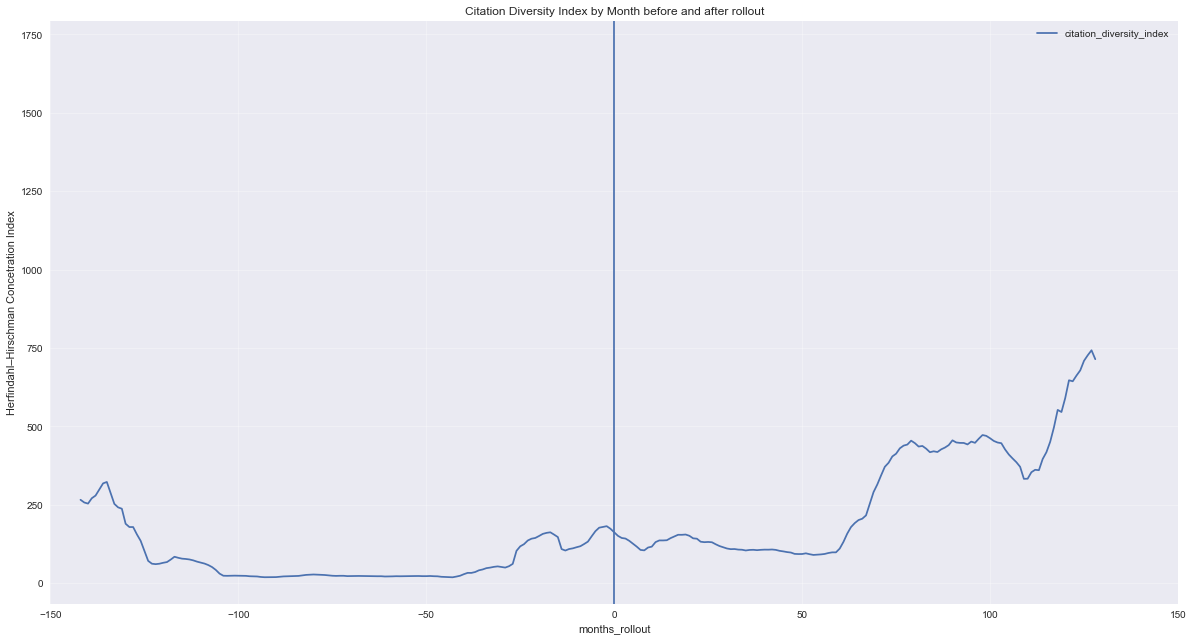

In [170]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
citation_diversity_es.plot(figsize=(18,10), ax=ax, xlim=(-150,150), title='Citation Diversity Index by Month before and after rollout')
ax.set_ylabel('Herfindahl–Hirschman Concetration Index')
plt.grid(alpha=0.3)
plt.axvline(0)
plt.savefig('plot6.png')

### Act Citations Diversity
Perform the same analysis but for citation of acts instead of cases

In [171]:
def act_citation_diversity_es(df):
    hhi_indices = []
    for month in range(-211, 134):
        citation_counts_month = list(hp.acts_citation_count_dict(df.loc[(df.months_to_rollout==month), :]).values())
        if citation_counts_month:
            array_p_i = np.array(citation_counts_month)/sum(citation_counts_month)
            hhi = array_p_i * array_p_i * 10000
            hhi_indices.append(sum(hhi))
        else:
            hhi_indices.append(np.nan)
    return pd.DataFrame({'months_rollout': list(range(-211,134)), 'citation_diversity_index': hhi_indices})

acts_diversity_es = act_citation_diversity_es(df) 
acts_diversity_es.set_index('months_rollout', inplace=True)
acts_diversity_es = acts_diversity_es.rolling(12, center=True).mean()
acts_diversity_es

citation_diversity_index
months_rollout                          
-211                                 NaN
-210                                 NaN
-209                                 NaN
-208                                 NaN
-207                                 NaN
...                                  ...
 129                                 NaN
 130                                 NaN
 131                                 NaN
 132                                 NaN
 133                                 NaN

[345 rows x 1 columns]

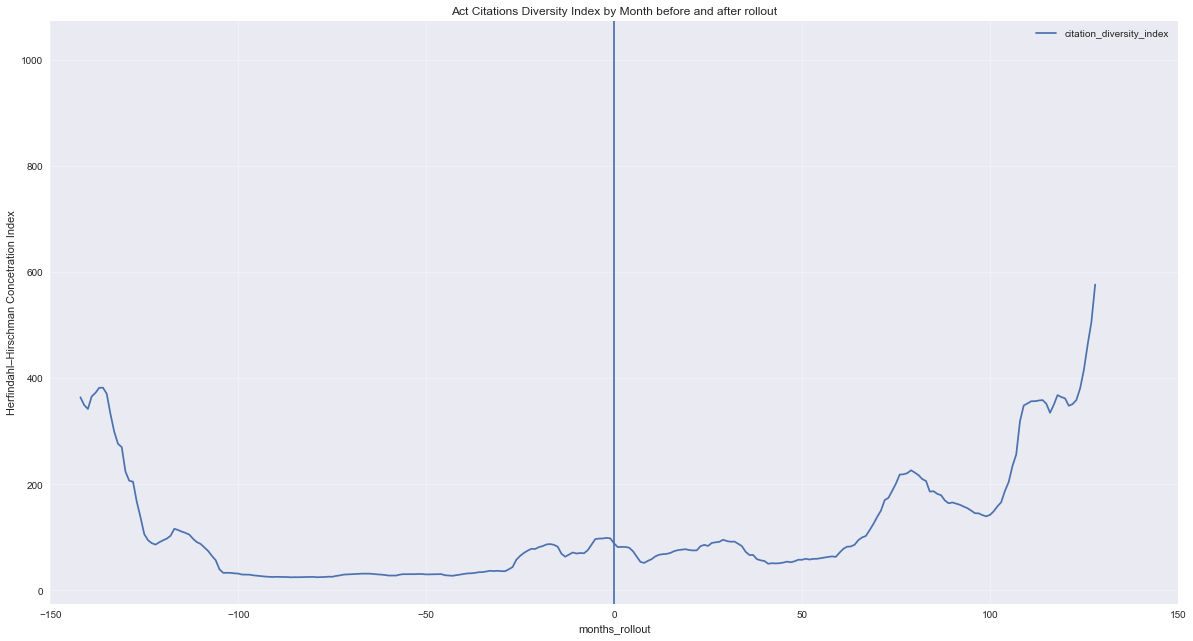

In [172]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
acts_diversity_es.plot(figsize=(18,10), ax=ax, xlim=(-150,150), title='Act Citations Diversity Index by Month before and after rollout')
ax.set_ylabel('Herfindahl–Hirschman Concetration Index')
plt.grid(alpha=0.3)
plt.axvline(0)
plt.savefig('plot7.png')